In [53]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit import transpile
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit.visualization import plot_histogram
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [44]:
def zz_feature_map(x):
    n = len(x)  # Number of features (qubits)
    qc = QuantumCircuit(n)

    # Step 1: Apply Hadamard gates
    for i in range(n):
        qc.h(i)

    # Step 2: Encode the individual features
    for i in range(n):
        qc.rz(2 * x[i], i)

    # Step 3: Encode pairwise interactions
    for i in range(n):
        for j in range(i + 1, n):
            qc.cx(i, j)
            qc.rz(2 * x[i] * x[j], j)
            qc.cx(i, j)  # Undo the CX gate

    return qc



In [45]:
def cswap_test(circuit1, circuit2):
    n = circuit1.num_qubits  # Number of qubits in each encoded circuit

    # Create a new circuit: 1 ancilla + qubits for circuit1 + qubits for circuit2
    qc = QuantumCircuit(1 + 2 * n, 1)

    # Add the encoded circuits
    qc.compose(circuit1, qubits=range(1, n + 1), inplace=True)
    qc.compose(circuit2, qubits=range(n + 1, 2 * n + 1), inplace=True)

    # Hadamard on the ancilla
    qc.h(0)

    # CSWAP Gates (Controlled SWAP between corresponding qubits)
    for i in range(n):
        qc.cswap(0, i + 1, i + 1 + n)

    # Second Hadamard on the ancilla
    qc.h(0)

    # Measurement
    qc.measure(0, 0)

    return qc

In [46]:
def quantum_kernel(qc1, qc2):
    # qc1 = zz_feature_map(x1)
    # qc2 = zz_feature_map(x2)
    
    cswap = cswap_test(qc1, qc2)

    # Generate a simulated backend with appropriate qubit count
    # backend = GenericBackendV2(num_qubits=qc1.num_qubits * 2 + 1)
    backend = AerSimulator(method='statevector')

    # Transpile the circuit for the backend
    transpiled_circuit = transpile(cswap, backend, optimization_level=3)

    # Run the transpiled circuit
    job = backend.run(transpiled_circuit)
    counts = job.result().get_counts()

    # Calculate probability of measuring '0' on the ancilla
    P_0 = counts.get('0', 0) / sum(counts.values())

    # Compute inner product with correction
    return max(0, 2 * P_0 - 1)


In [50]:
# Data generation
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
y = 2 * y - 1  # Convert labels from {0,1} to {-1,1}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Quantum Kernel
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

# Compute quantum kernel matrix
encoded_qcircuits = [zz_feature_map(x) for x in X_train]

K_quantum = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    for j in range(i, len(X_train)):  
        similarity = quantum_kernel(encoded_qcircuits[i], encoded_qcircuits[j])
        K_quantum[i][j] = K_quantum[j][i] = similarity

# SMO Algorithm for training
def smo(K, X, y, C=1.0, tol=1e-5, max_iter=1000):
    n_samples = X.shape[0]
    alpha = np.zeros(n_samples)
    b = 0

    for _ in range(max_iter):
        num_changed_alphas = 0
        for i in range(n_samples):
            E_i = np.sum(alpha * y * K[i, :]) + b - y[i]
            if (y[i] * E_i < -tol and alpha[i] < C) or (y[i] * E_i > tol and alpha[i] > 0):
                j = np.random.choice([idx for idx in range(n_samples) if idx != i])
                E_j = np.sum(alpha * y * K[j, :]) + b - y[j]

                alpha_i_old, alpha_j_old = alpha[i], alpha[j]

                if y[i] != y[j]:
                    L, H = max(0, alpha[j] - alpha[i]), min(C, C + alpha[j] - alpha[i])
                else:
                    L, H = max(0, alpha[i] + alpha[j] - C), min(C, alpha[i] + alpha[j])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue

                alpha[j] -= y[j] * (E_i - E_j) / eta
                alpha[j] = np.clip(alpha[j], L, H)

                if abs(alpha[j] - alpha_j_old) < tol:
                    continue

                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])

                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i, i] - y[j] * (alpha[j] - alpha_j_old) * K[i, j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i, j] - y[j] * (alpha[j] - alpha_j_old) * K[j, j]

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                num_changed_alphas += 1

        if num_changed_alphas == 0:
            break

    # Store non-zero alphas with corresponding x and y
    alpha_map = [
        {"alpha": alpha[i], "x": X[i], "y": y[i]} 
        for i in range(n_samples) if alpha[i] > 0
    ]

    return alpha_map, b

# Classification function
def classify(x_new, alpha_map, b):
    K_new = np.array([quantum_kernel(zz_feature_map(x["x"]), zz_feature_map(x_new)) for x in alpha_map])
    decision_value = np.sum([x["alpha"] * x["y"] * k for x, k in zip(alpha_map, K_new)]) + b
    return np.sign(decision_value)

# Train the model
alpha_map, b = smo(K_quantum, X_train, y_train)

# Predictions
y_pred = np.array([classify(x, alpha_map, b) for x in X_test])

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Visualization
# plt.figure(figsize=(8, 6))
# for i, point in enumerate(X_test):
#     if y_test[i] == 1:
#         plt.scatter(point[0], point[1], color='blue', marker='o')
#     else:
#         plt.scatter(point[0], point[1], color='red', marker='x')

# plt.title('Quantum Kernel SVM Decision Boundary')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend(['Positive', 'Negative'])
# plt.show()

Accuracy: 0.5
Precision: 0.5333333333333333
Recall: 0.5
F1 Score: 0.5161290322580645


C:\Users\Akram\AppData\Local\Temp\ipykernel_10432\1720142390.py:8: QiskitMachineLearningWarning: 'No quantum kernel is provided, SamplerV1 based quantum kernel will be used.'
  qsvc = QSVC()


Accuracy: 0.5333333333333333
Precision: 0.5625
Recall: 0.5625
F1 Score: 0.5625


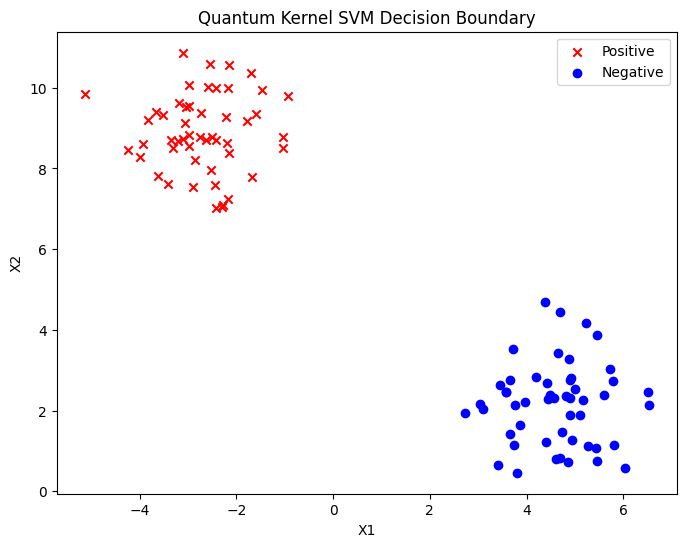

In [58]:
# Data generation
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
y = 2 * y - 1  # Convert labels from {0,1} to {-1,1}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

qsvc = QSVC()
qsvc.fit(X_train,y_train)

# Predictions
y_pred = qsvc.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Visualization
plt.figure(figsize=(8, 6))
for i, point in enumerate(X):
    if y[i] == 1:
        plt.scatter(point[0], point[1], color='blue', marker='o')
    else:
        plt.scatter(point[0], point[1], color='red', marker='x')

plt.title('Quantum Kernel SVM Decision Boundary')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(['Positive', 'Negative'])
plt.show()